In [24]:
import tensorflow as tf
from nbodykit.lab import *
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
tf.executing_eagerly()
%matplotlib inline

# General Autodiff... vmad->tensorflow

I think I get the gist of it, but Im sure theres alot of features I dont even know about. But I can do the simple things, write a function, take a gradient with respect to some variable, write a custom gradient. I think I'm set with tf autodiff. Gonna do some of things that got me started with vmad though 

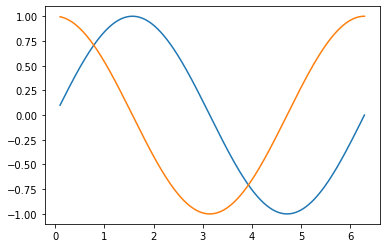

In [25]:
# Start with a sine wave and make sure I understand how it all works
x = tf.linspace(0.1, 2*np.pi, 1000, name='radians', )
with tf.GradientTape() as g:
    g.watch(x)
    y = tf.sin(x)
plt.figure(figsize=(6, 4))
plt.plot(x, y)
plt.plot(x, g.gradient(y, x))
plt.show()

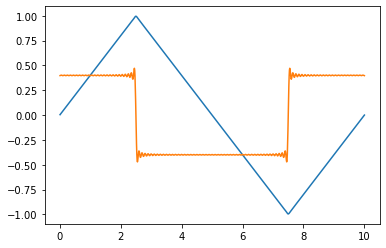

In [26]:
# ok so super easy. Thats awesome. Now if I want to make a more complicated function...
# The derivative of a triangle wave is a square wave so0o0o0o

def triangle(x, n, L=5, name='tri_wave'):
    with tf.name_scope(name):
        freq = tf.einsum('i, j->ij', x, tf.multiply(n,np.pi/L))
        sins = tf.multiply(tf.sin(freq), 8/np.pi**2)
        weights = tf.divide(tf.pow((-1), (n-1)/2), tf.pow(n, 2))
        return tf.math.reduce_sum(tf.multiply(sins, weights), axis=1)

n = tf.range(1, 101, delta=2, dtype='float')
x = tf.linspace(.01, 10.0, 1000, )

with tf.GradientTape() as g:
    g.watch(x)
    tr = triangle(x, n)
    
plt.figure(figsize=(6,4))
plt.plot(x, tr)
plt.plot(x, g.gradient(tr, x))
plt.show()

In [27]:
# Sickkkkk. Ok, now for registering my own gradient. 
def parab(x, a=2):
    return a*x**2
@tf.RegisterGradient('parab')
def _parab(x, a=2):
    return 2*a*x

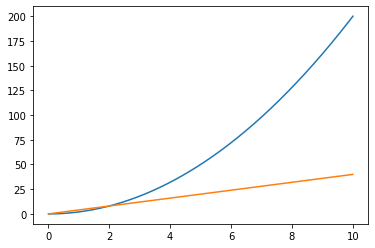

In [31]:
with tf.GradientTape() as g:
    g.watch(x)
    f = parab(x)
plt.figure(figsize=(6, 4))
plt.plot(x, f)
plt.plot(x, g.gradient(f, x))
plt.show()


# Rotations to fill lightcone

We have some source distance ```ds``` and at each fastpm step we have an initial distance ```di``` and ```df``` after the pm step (from observer perspective). To fill the space between fastpm steps, we need to worry about the $z$ direction, and the $x-y$ plane. From fastpm, we only allow $90^\circ$, or $6$, unique rotations in the z direction, and two box replications in the $x-y$ plane. ```generate``` finds how many, $N$, rotations are required between steps and how many replications in the $x-y$ plane.

**Rotation**

Create a list of $N$ rotations drawn from the $6$ allowable ones. It repeats rotations if the number required is over $6$. 

**Translation**

To actually move the box forward in $z$ and fill up the $x-y$ plane, ```generate``` also saves a ```boxshift``` with each rotation matrix. If there is only $1$ box replication required, that means that the 2D projection field, determined by the field of view and distance to the source, is the same area as the $x-y$ area of the ```boxsize```. If there are $2$ replications claimed to be required, then there are $4$ possible translations. For each of the $N$ required steps, one of these translations will be saved where we have replicated in the $x-y$ direction and added $N_i\hat{z}$ to the translation so that it moves forward in $z$


**Application**

After finding the number of rotations required, ```rotate``` takes one rotation matrix and translation and applies it to the particle positions inside the box. 

In [32]:
def generate(di, df, ds, boxsize, boxsize2D):
    """ Returns a list of rotation matrices and shifts that are applied to the box
    di : distance to inital redshift (before taking fastpm step)
    df : distance to final redshift (after taking fastpm step)
    ds : Source distance
    boxsize: size of computational box
    """
    # Generate the possible rotation matrices
    x      = np.asarray([1,0,0],dtype=int)
    y      = np.asarray([0,1,0],dtype=int)
    z      = np.asarray([0,0,1],dtype=int)

    # shuffle directions, only 90 deg rotations, makes a total of 6
    M_matrices = [np.asarray([x,y,z],dtype=int), np.asarray([x,z,y],dtype=int),np.asarray([z,y,x],dtype=int),np.asarray([z,x,y],dtype=int), \
                         np.asarray([y,x,z],dtype=int), np.asarray([y,z,x],dtype=int)]
    # Generate possible xy shifts
    I = np.zeros(3)
    fac =0.5
    xyshifts = [np.asarray([fac,fac,0.],dtype=float),np.asarray([-fac,fac,0.],dtype=float),np.asarray([-fac,-fac,0.],dtype=float),np.asarray([fac,- fac,0.],dtype=float)]

    # Find the maximum number of rotations needed in the xy direction
    vert_num = round(ds * boxsize2D / boxsize[-1])

    print('rotations available: %d'%len(M_matrices))
    print('rotations required: %d'%np.ceil(ds/boxsize[-1]))

    try:
        assert(len(M_matrices)*boxsize[-1]>ds)
        print('sufficient number of rotations to fill lightcone.')
    except:
        print('insufficient number of rotations to fill the lightcone.')
    if df>ds:
        return 0, 0
    else:
        shift_ini = np.floor(max(di,ds)/boxsize[-1])
        shift_end = np.floor(df/boxsize[-1])
        M = []
        if vert_num==1:
            for ii in np.arange(shift_end,shift_ini+1,dtype=int):
                M.append((M_matrices[ii%len(M_matrices)], I+ii*z))
        elif vert_num==2:
            for ii in np.arange(shift_end,shift_ini+1,dtype=int):
                for jj in range(4):
                    M.append((M_matrices[ii%len(M_matrices)], I+ii*z+xyshifts[jj]))
        else:
            raise ValueError('vertical number of boxes must be 1 or 2, but is %d'%vert_num)

        return M
def rotate(x, M, boxshift, boxsize, name='rotate'):
    """
    rotates, shift, and separates particle coordinates into distance and xy position
    x:        particle positions
    M:        rotation matrix
    boxshift: shift vector
    """
    #TODO make this tensorflow compat and return xy, d tensors
    with tf.name_scope(name):
        y  = tf.einsum('ij,kj->ki', M, x)
        y  = tf.add(y, boxsize*boxshift)
        d  = tf.gather(y, 2, axis=1, name='gather_z')
        xy = tf.gather(y, (0, 1), axis=1, name='gather_xy')
        return xy, d
def get_fov(cosmo,BoxSize,z_source):
    """
    get the optimal field of view (in degrees) for given boxsize and source redshift
    """
    chi_source = cosmo.angular_diameter_distance(z_source)*(1+z_source)
    fov        = BoxSize/chi_source/np.pi*180.
    return fov

In [33]:
# Create a cosmology and source redshift to find some distances
z = .1
cosmo = cosmology.Planck15
ds = cosmo.comoving_distance(z)

# Make distances mimiking the fastpm steps, and lets just start at the source and end at the
# observer (this is unrealistic, there should be multiple fast pm steps in between)
df = ds-8
di = ds
dx=3
# Make a boxsize and find the projection boxsize (fov) in radian
boxsize = [4]*3
boxsize2D = get_fov(cosmo, boxsize[0], z)*np.pi/180

#Generate the rotation matrices needed to fill the lightcone
M = generate(di, df, ds, boxsize, boxsize2D)

# Initialize particle distances centered at pre-step
x = tf.random.normal((16**3, 3), mean=di)
dx = tf.random.normal((16**3, 3), mean=0)

rotations available: 6
rotations required: 74
insufficient number of rotations to fill the lightcone.


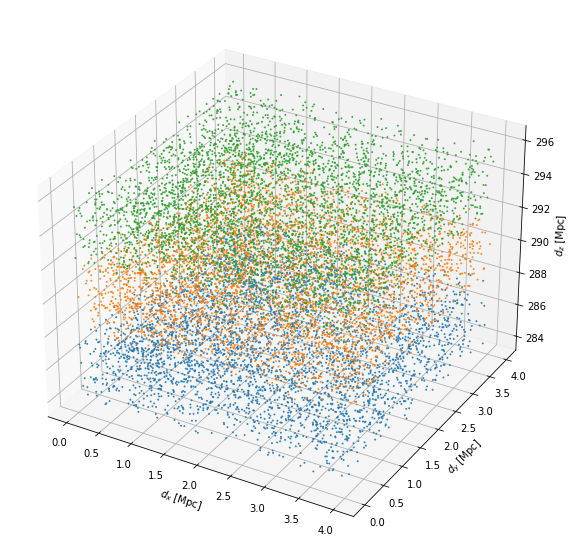

In [36]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection='3d')

# ax.scatter(tf.math.mod(x,boxsize)[:,0], tf.math.mod(x,boxsize)[:,1], tf.math.mod(x,boxsize)[:,2], c='k')
with tf.GradientTape() as g:
    g.watch(x)
    for Mi, boxshift in M:
        xy, d = rotate(tf.math.mod(tf.add(x,dx),boxsize), Mi, boxshift, boxsize)

        xs = xy[:, 0]
        ys = xy[:,1]
        zs = d
        ax.scatter(xs, ys, zs, s=1, alpha=.8)



    ax.set_xlabel(r'$d_x$ [Mpc]')
    ax.set_ylabel(r'$d_y$ [Mpc]')
    ax.set_zlabel(r'$d_z$ [Mpc]')

    plt.show()



# Lensing Efficiency Kernel

The Lensing kernel weighs the shape distortions with respect to distance from the observer. So theres two parts, I need to create a function which calculates the redshift for each particle based off of position, and find the column density density of the particles. The column density is in units of $1/L$, and depends on the pixel size of the projected mesh

In [37]:
import scipy

In [38]:
def z_chi(d, cosmo, name='z_chi'):
    with tf.name_scope(name):
        # redshift as a function of comsoving distance for underlying cosmology
        z_int          = np.logspace(-12,np.log10(1500),40000)
        chis           = cosmo.comoving_distance(z_int) #Mpc/h
        z_chi_int = scipy.interpolate.interp1d(chis, z_int, kind='linear', bounds_error=False, fill_value='extrapolate')
        z = z_chi_int(d)
        return z 

@tf.RegisterGradient('z_chi')
def _z_chi(z, cosmo):
    return cosmo.efunc(z)*cosmo.H0/cosmo.C

In [39]:
def wlen(d, ds, cosmo, boxsize, boxsize2D, mesh2D):
        """
        returns the correctly weighted lensing efficiency kernel
        d:   particle distance (assuming parllel projection)
        ds:  source redshift
        """
        # Find the redshift at ds
        z          = z_chi(d, cosmo)
        # Find the number density of simulated particles
        nbar = tf.shape(d)/boxsize[0]**3
        
        #Find angular pixel area for projection
        A = mesh2D[0]**2/boxsize2D**2
        columndens = tf.multiply(tf.pow(d,2),float(nbar*A)) #particles/Volume*angular pixel area* distance^2 -> 1/L units
        w          = tf.divide(tf.multiply(tf.multiply(tf.subtract(ds, d), tf.divide(d, ds)), (1.+z)), columndens) #distance
        return w

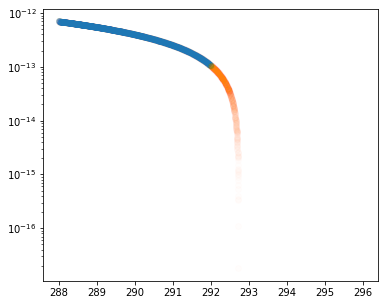

In [40]:
mesh2D = [16]*2

plt.figure(figsize=(6,5))
for Mi, boxshift in M[1:]:
    xy, d = rotate(tf.math.mod(tf.add(x,dx),boxsize), Mi, boxshift, boxsize)
    eff = wlen(d, ds, cosmo, boxsize, boxsize2D, mesh2D)
    plt.semilogy(d, eff, 'o', alpha=.01)

# Make map

Ok, this is where I'm getting stuck. We need to project onto a 2D mesh. So we have the 2D particle positions (xy) and we have the (ideally) the mesh that were projecting onto... But how do I do a 2D projection in flowpm? it seems that there is only a 3D cic_paint. is there something equivalent to ```layout``` in flowpm?

In [41]:
import flowpm

In [42]:
def makemap(mesh, xy, w):
    """
    paint projected particles to 2D mesh
    xy: particle positions in radians
    w:  weighting = projection kernel
    """
#     if (self.mappm.affine.period != 0).any():
#         raise RuntimeError("The ParticeMesh object must be non-periodic")
#     if self.mappm.ndim != 2:
#         raise RuntimeError("The ParticeMesh object must be 2 dimensional. ")

#     compensation = self.mappm.resampler.get_compensation()

#     layout       = fastpm.decompose(xy, self.mappm)
    map          = flowpm.cic_paint(mesh, xy, weight=w)
    # compensation for cic window
#     c            = fastpm.r2c(map)
#     c            = fastpm.apply_transfer(c, lambda k : compensation(k, 1.0), kind='circular')
#     map          = fastpm.c2r(c)

    return map

In [43]:
# makemap(tf.Variable((16,16)), xy, eff)

# Mask